# Regularization and Evaluation of Neural Networks

In [1]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn #necessary for eval.
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [4]:
digits = load_digits()
X_data = digits.data
y_target = digits.target
X = np.asarray(X_data).astype(np.float32)
y = np.asarray(y_target).astype(np.float32)

y_binary = y % 2

In [5]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=30, batch_size=30)

Epoch 1/30
60/60 [==============================] - 0s 2ms/step - loss: 1.1908 - accuracy: 0.5465
Epoch 2/30
60/60 [==============================] - 0s 2ms/step - loss: 0.4620 - accuracy: 0.7769
Epoch 3/30
60/60 [==============================] - 0s 1ms/step - loss: 0.3705 - accuracy: 0.8191
Epoch 4/30
60/60 [==============================] - 0s 1ms/step - loss: 0.3079 - accuracy: 0.8564
Epoch 5/30
60/60 [==============================] - 0s 1ms/step - loss: 0.2527 - accuracy: 0.9009
Epoch 6/30
60/60 [==============================] - 0s 995us/step - loss: 0.2123 - accuracy: 0.9226
Epoch 7/30
60/60 [==============================] - 0s 1ms/step - loss: 0.1843 - accuracy: 0.9293
Epoch 8/30
60/60 [==============================] - 0s 1ms/step - loss: 0.1659 - accuracy: 0.9371
Epoch 9/30
60/60 [==============================] - 0s 1ms/step - loss: 0.1459 - accuracy: 0.9488
Epoch 10/30
60/60 [==============================] - 0s 1ms/step - loss: 0.1334 - accuracy: 0.9499
Epoch 11/30
60/60

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [6]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [7]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to? the # of features, or columns
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 1ms/step - loss: 0.6986 - accuracy: 0.5039
Epoch 2/10
12/12 [==============================] - 0s 971us/step - loss: 0.6968 - accuracy: 0.5039
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6952 - accuracy: 0.5039
Epoch 4/10
12/12 [==============================] - 0s 1ms/step - loss: 0.6942 - accuracy: 0.5039
Epoch 5/10
12/12 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5039
Epoch 6/10
12/12 [==============================] - 0s 1ms/step - loss: 0.6926 - accuracy: 0.5039
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6921 - accuracy: 0.5039
Epoch 8/10
12/12 [==============================] - 0s 1ms/step - loss: 0.6916 - accuracy: 0.5039
Epoch 9/10
12/12 [==============================] - 0s 1ms/step - loss: 0.6913 - accuracy: 0.5039
Epoch 10/10
12/12 [==============================] - 0s 1ms/step - loss: 0.6911 - accuracy: 0.5039


We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [8]:
results.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x1b5bf1af040>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.6986391544342041,
   0.6967519521713257,
   0.6952065825462341,
   0.6941612362861633,
   0.6933199167251587,
   0.6926121711730957,
   0.6920729875564575,
   0.6916458010673523,
   0.6913238167762756,
   0.6910783648490906],
  'accuracy': [0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

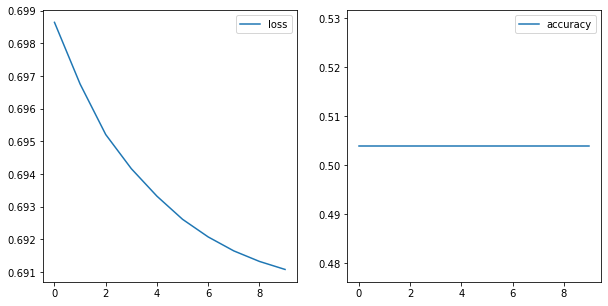

In [9]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

# loss is not reaching a low value, and accuracy curve is garbage

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [10]:
X_pure_train.shape[0]

1149

In [11]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',  #stochastic grade descent
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
results = model.fit(X_pure_train, y_pure_train, epochs=50, batch_size=50, verbose=1)

# 30 epochs was not enough.  Still learning.  Upped to 50
# 50 still didn't assymptote out on plot below.  Trying to hit the
# minimum, and accuracy should be going up and up and up


Epoch 1/50
23/23 [==============================] - 0s 2ms/step - loss: 0.6797 - accuracy: 0.5883
Epoch 2/50
23/23 [==============================] - 0s 1ms/step - loss: 0.6732 - accuracy: 0.6162
Epoch 3/50
23/23 [==============================] - 0s 1ms/step - loss: 0.6669 - accuracy: 0.6249
Epoch 4/50
23/23 [==============================] - 0s 2ms/step - loss: 0.6603 - accuracy: 0.6728
Epoch 5/50
23/23 [==============================] - 0s 981us/step - loss: 0.6529 - accuracy: 0.7023
Epoch 6/50
23/23 [==============================] - 0s 946us/step - loss: 0.6452 - accuracy: 0.7206
Epoch 7/50
23/23 [==============================] - 0s 945us/step - loss: 0.6372 - accuracy: 0.7232
Epoch 8/50
23/23 [==============================] - 0s 1ms/step - loss: 0.6284 - accuracy: 0.7380
Epoch 9/50
23/23 [==============================] - 0s 960us/step - loss: 0.6187 - accuracy: 0.7441
Epoch 10/50
23/23 [==============================] - 0s 725us/step - loss: 0.6075 - accuracy: 0.7607
Epoch 11/

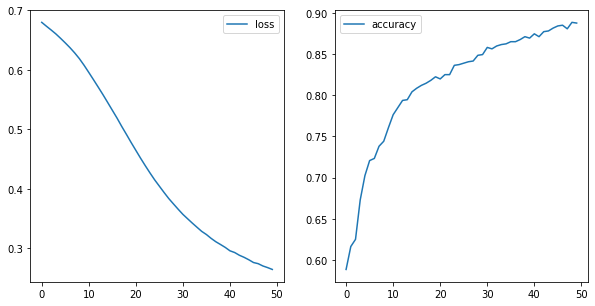

In [12]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

If we increase the learning rate to a very high number (too big a step size), we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
115/115 [==============================] - 0s 2ms/step - loss: 518.9327 - accuracy: 0.5004
Epoch 2/30
115/115 [==============================] - 0s 1ms/step - loss: 0.9891 - accuracy: 0.4978
Epoch 3/30
115/115 [==============================] - 0s 1ms/step - loss: 1.1581 - accuracy: 0.4639
Epoch 4/30
115/115 [==============================] - 0s 921us/step - loss: 1.0453 - accuracy: 0.4909
Epoch 5/30
115/115 [==============================] - 0s 925us/step - loss: 1.0169 - accuracy: 0.4891
Epoch 6/30
115/115 [==============================] - 0s 980us/step - loss: 1.0034 - accuracy: 0.5144
Epoch 7/30
115/115 [==============================] - 0s 1ms/step - loss: 1.0140 - accuracy: 0.4996
Epoch 8/30
115/115 [==============================] - 0s 1ms/step - loss: 0.9397 - accuracy: 0.5030
Epoch 9/30
115/115 [==============================] - 0s 1ms/step - loss: 0.9915 - accuracy: 0.5100
Epoch 10/30
115/115 [==============================] - 0s 944us/step - loss: 0.9681 - accura

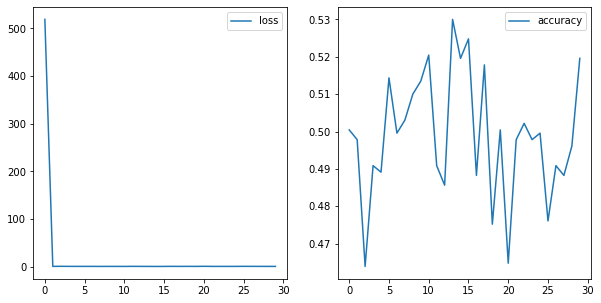

In [13]:
model = Sequential()

sgd = SGD(learning_rate=9) #exploding our learning rate. Default =.01
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,  # different thant string called earlier
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

# bouncing all around because step size is WAY too big

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

Epoch 1/30
115/115 [==============================] - 2s 16ms/step - loss: 0.6613 - accuracy: 0.5979 - val_loss: 0.5982 - val_accuracy: 0.7396
Epoch 2/30
115/115 [==============================] - 0s 2ms/step - loss: 0.4841 - accuracy: 0.8007 - val_loss: 0.3795 - val_accuracy: 0.8507
Epoch 3/30
115/115 [==============================] - 0s 2ms/step - loss: 0.3147 - accuracy: 0.8721 - val_loss: 0.2665 - val_accuracy: 0.9097
Epoch 4/30
115/115 [==============================] - 0s 2ms/step - loss: 0.2305 - accuracy: 0.9069 - val_loss: 0.2167 - val_accuracy: 0.9167
Epoch 5/30
115/115 [==============================] - 0s 2ms/step - loss: 0.1844 - accuracy: 0.9278 - val_loss: 0.1617 - val_accuracy: 0.9444
Epoch 6/30
115/115 [==============================] - 0s 2ms/step - loss: 0.1535 - accuracy: 0.9391 - val_loss: 0.1560 - val_accuracy: 0.9410
Epoch 7/30
115/115 [==============================] - 0s 1ms/step - loss: 0.1309 - accuracy: 0.9565 - val_loss: 0.1187 - val_accuracy: 0.9618
Epoch

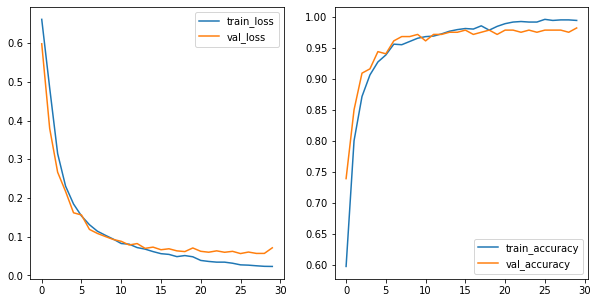

In [14]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',  # using Adam now
              loss='binary_crossentropy',
              metrics=['accuracy'])  #can look at a bunch of different metrics


## YOUR CODE HERE

# talked about validation_split (splits training data for us)
# validation_data (can be a tuple of x_val and y_val)
results = model.fit(X_pure_train, y_pure_train, 
                    epochs=30, batch_size=10, verbose=1,
                   validation_data=(X_val, y_val))

# so using sklearn train_test_split is better than val_split


train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

# now we have val_loss and val_accuracy
# so we can validate our model withOUT using our test data

# cool visuals.  The goal is to see those lines touching, with loss
# as close to zero as possible, and accuracy as close to 1

# these are still overfitting

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [15]:
results.history['val_accuracy'][-1]

0.9826388955116272

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [16]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

# can't just cross val the model.  Why not, if it's an estimator?
# well it's still a tensorflow object, not an OOP estimator

# we have to WRAP IT

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001B5E63D8CA0> does not.

In [17]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [18]:
# can't just feed our model in, we need a build function
# that represents our model.  THAT will return our compiled model.
# and we give that function to our wrapper, with all parameters (that
# we would have passed in to our .fit)

keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=50,
                                          batch_size=32,
                                          verbose=2)

# warning that this will depreciate soon.  
# So there will be a different way to do this in the future

In [19]:
type(keras_model)

# it's a wrapper!

tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier

In [20]:
# Can now cross_val
cross_val_score(keras_model, X_pure_train, y_pure_train, cv=3)

# took about 45 sec?  Would be a lot longer with a larger model

# ultimately: we can cross val a neural network if we want

Epoch 1/50
24/24 - 0s - loss: 0.6788 - accuracy: 0.5339
Epoch 2/50
24/24 - 0s - loss: 0.6437 - accuracy: 0.6175
Epoch 3/50
24/24 - 0s - loss: 0.5957 - accuracy: 0.6749
Epoch 4/50
24/24 - 0s - loss: 0.5494 - accuracy: 0.7742
Epoch 5/50
24/24 - 0s - loss: 0.5135 - accuracy: 0.8146
Epoch 6/50
24/24 - 0s - loss: 0.4871 - accuracy: 0.8512
Epoch 7/50
24/24 - 0s - loss: 0.4662 - accuracy: 0.8681
Epoch 8/50
24/24 - 0s - loss: 0.4492 - accuracy: 0.8773
Epoch 9/50
24/24 - 0s - loss: 0.4344 - accuracy: 0.8877
Epoch 10/50
24/24 - 0s - loss: 0.4219 - accuracy: 0.8982
Epoch 11/50
24/24 - 0s - loss: 0.4096 - accuracy: 0.8995
Epoch 12/50
24/24 - 0s - loss: 0.4008 - accuracy: 0.9099
Epoch 13/50
24/24 - 0s - loss: 0.3915 - accuracy: 0.9112
Epoch 14/50
24/24 - 0s - loss: 0.3797 - accuracy: 0.9204
Epoch 15/50
24/24 - 0s - loss: 0.3699 - accuracy: 0.9295
Epoch 16/50
24/24 - 0s - loss: 0.3651 - accuracy: 0.9230
Epoch 17/50
24/24 - 0s - loss: 0.3549 - accuracy: 0.9321
Epoch 18/50
24/24 - 0s - loss: 0.3467 - 

Epoch 44/50
24/24 - 0s - loss: 0.0447 - accuracy: 0.9896
Epoch 45/50
24/24 - 0s - loss: 0.0431 - accuracy: 0.9883
Epoch 46/50
24/24 - 0s - loss: 0.0408 - accuracy: 0.9922
Epoch 47/50
24/24 - 0s - loss: 0.0402 - accuracy: 0.9922
Epoch 48/50
24/24 - 0s - loss: 0.0383 - accuracy: 0.9935
Epoch 49/50
24/24 - 0s - loss: 0.0372 - accuracy: 0.9948
Epoch 50/50
24/24 - 0s - loss: 0.0347 - accuracy: 0.9922
12/12 - 0s - loss: 0.1071 - accuracy: 0.9556


array([0.92167103, 0.94778067, 0.95561355])

## Regularization

Does regularization make sense in the context of neural networks? <br/>

**Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.**

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

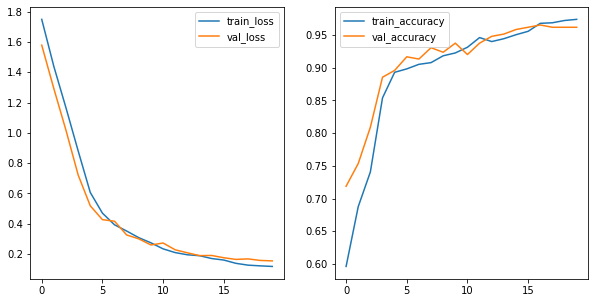

In [21]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu', 
                kernel_regularizer=l2(l2=0.05)))  
# added kernel_regularizer.  Could add this to any of the dense layers too
# this is only penalizing the weights

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

# verbosity is 0, speeds up training time a little

# plots: 

Adding L2 to multiple layers:

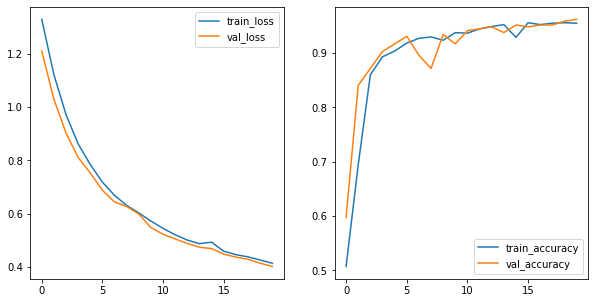

In [22]:
# this is going to the extreme

model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

# pretty similar, though we did smooth out plots.
# still overfitting some though
# already using relu too (which turns off nodes for neg. numbers)

# can add a separate dropout layer too, to randomly shut off other nodes
# see below

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

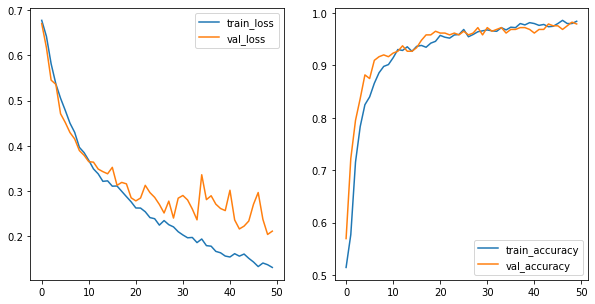

In [23]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(rate=0.5))
    # how many nodes to turn off?  rate. 0.5 = 50%
    # added a dropout layer here.  Applies itself to the previous layer
model.add(Dense(12, activation='relu'))
model.add(Dropout(rate=0.5))  # and here
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

#  pretty decently fit model, via dropout (another form of regularization basically)

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [24]:
results.history['val_accuracy'][-1]

# up to .9826 now

0.9791666865348816

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

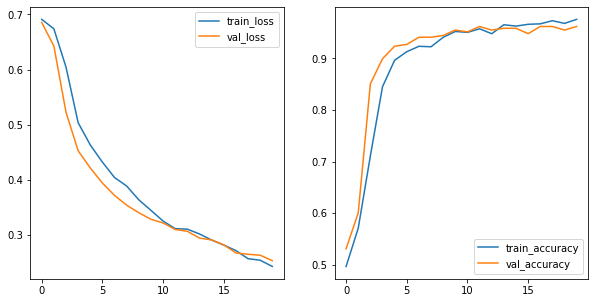

In [25]:
# talked about setting a tolerance for gradient descent.  Going to 
# try that here
# we'll stop the model if accuracy does not improve by a certain amount
# over a certain number of epochs.  See early stopping object below...

model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object  (a Tensorflow class)
# tell it what you want to monitor (e.g. val_loss - looking for min
# or val_accuracy - looking for max)
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

# initially the model stopped WAAY too early.  
# that's because it's looking for a change between EVERY epoch.  
# need to space it out...  will pass patience parameter below

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 00021: early stopping


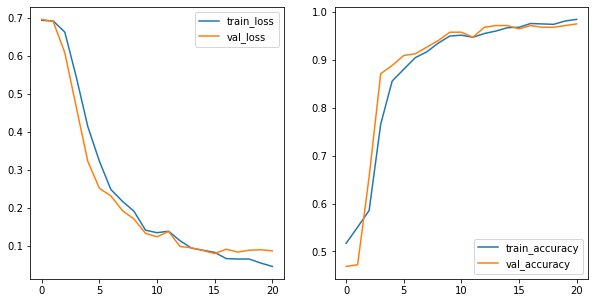

In [26]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1, patience=5,  # patience parameter - after 5 epochs, if loss not...
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])  # need a callback in our .fit too

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

# we stopped at epoch 34.  Didn't make it to 50
# because of our callback
# like another form of regularization, to avoid overfitting

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object



# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [27]:
results.history['val_accuracy'][-1]

# now .9757

0.9756944179534912

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [28]:
digits = load_digits()
X = digits.data
y = digits.target

# no binary target here.  This is a full multiclass problem

# softmax puts out probabilities, floats between 0 and 1, and they
# will all total to 1.  And we can pick the highest probability

# it involves transforming our y data (!)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [ ]:
# it needs to be one hot encoded out.  Not dropping a category though

# so this is transforming y_pure_train

In [30]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [31]:
y_pure_train.reshape(-1,1)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]])

In [32]:
y_test

# so 1st row below matches the above

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# an OHE 9 would be:
# 9 = [0,0,0,0,0,0,0,0,1]

In [33]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
# Final layer will look different need a node for each class
model.add(Dense(10, activation='softmax'))  # this is what we added
# we need 10 probabilities, not the binary of sigmoid function

model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # this is new too, not binary
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 0s 4ms/step - loss: 2.1627 - accuracy: 0.2959 - val_loss: 2.0414 - val_accuracy: 0.3681
Epoch 2/50
115/115 [==============================] - 0s 2ms/step - loss: 1.8580 - accuracy: 0.4282 - val_loss: 1.7350 - val_accuracy: 0.4792
Epoch 3/50
115/115 [==============================] - 0s 2ms/step - loss: 1.5268 - accuracy: 0.5570 - val_loss: 1.4259 - val_accuracy: 0.6319
Epoch 4/50
115/115 [==============================] - 0s 3ms/step - loss: 1.2255 - accuracy: 0.6893 - val_loss: 1.1689 - val_accuracy: 0.7118
Epoch 5/50
115/115 [==============================] - 0s 2ms/step - loss: 0.9870 - accuracy: 0.7737 - val_loss: 0.9763 - val_accuracy: 0.7049
Epoch 6/50
115/115 [==============================] - 0s 1ms/step - loss: 0.8147 - accuracy: 0.7998 - val_loss: 0.8147 - val_accuracy: 0.7778
Epoch 7/50
115/115 [==============================] - 0s 1ms/step - loss: 0.6789 - accuracy: 0.8320 - val_loss: 0.6977 - val_accuracy: 0.8090
Epoch 

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [34]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

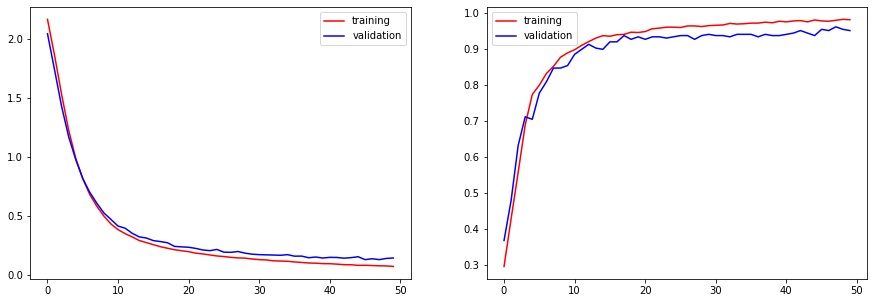

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [36]:
model.predict(X_test)

array([[1.4592889e-04, 2.9752523e-04, 5.2039223e-08, ..., 6.2983789e-12,
        1.8830750e-03, 1.9571537e-06],
       [4.6497782e-05, 1.5868917e-06, 2.2526998e-10, ..., 5.6988585e-05,
        1.2226234e-04, 9.9852931e-01],
       [6.7187067e-08, 8.6537995e-07, 9.0035121e-04, ..., 7.6346541e-06,
        7.6092285e-04, 1.5844746e-03],
       ...,
       [4.5928678e-06, 2.7564583e-02, 3.6456226e-05, ..., 2.3640392e-02,
        9.4456798e-01, 6.0528837e-04],
       [1.4646803e-06, 1.9201354e-04, 4.7239899e-03, ..., 5.9626258e-05,
        8.6945118e-03, 5.1354137e-03],
       [1.7387518e-07, 3.1260899e-07, 9.2933057e-08, ..., 6.2325756e-10,
        3.3336914e-06, 3.8976963e-03]], dtype=float32)

In [37]:
model.predict(X_test)[0]

array([1.4592889e-04, 2.9752523e-04, 5.2039223e-08, 6.6278702e-08,
       4.7884695e-04, 1.6106985e-04, 9.9703157e-01, 6.2983789e-12,
       1.8830750e-03, 1.9571537e-06], dtype=float32)

In [36]:
len(model.predict(X_test)[0])

# the length of this is 10 - each of our 10 softmax

10

In [38]:
model.predict(X_test)[0].sum()

1.0000001

In [39]:
y_hat_test = np.argmax(model.predict(X_test), axis=-1)

# np.argmax returns the indices of the maximum value

In [40]:
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)

# that's an awesome confusion matrix

array([[30,  0,  0,  0,  1,  0,  1,  1,  0,  0],
       [ 0, 27,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 30,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  0,  1, 32,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0, 45,  1,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0, 29,  0],
       [ 0,  0,  0,  2,  0,  1,  0,  0,  2, 35]], dtype=int64)

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

